<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará el primer libro de 'Lord of the Rings' para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esta escrito el libro.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec
import os
import re

### Datos
Utilizaremos como dataset los libros 'Lord of the Rings'

In [2]:
# Posibles bandas
os.listdir("./book_dataset/")

['01 - The Fellowship Of The Ring.txt',
 '02 - The Two Towers.txt',
 '03 - The Return Of The King.txt']

In [122]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('./book_dataset//01 - The Fellowship Of The Ring.txt', sep='/n', header=None, encoding='latin-1')
# df1 = pd.read_csv('./book_dataset//01 - The Fellowship Of The Ring.txt', sep='/n', header=None, encoding='latin-1')
# df2 = pd.read_csv('./book_dataset//02 - The Two Towers.txt', sep='/n', header=None, encoding='latin-1')
# df3 = pd.read_csv('./book_dataset//03 - The Return Of The King.txt', sep='/n', header=None, encoding='latin-1')
# df = pd.concat([df1, df2, df3], ignore_index=True)
df.head()

/tmp/ipykernel_8023/1647752081.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,"Three Rings for the Elven-kings under the sky,"
1,Seven for the Dwarf-lords in their halls of st...
2,"Nine for Mortal Men doomed to die,"
3,One for the Dark Lord on his dark throne
4,In the Land of Mordor where the Shadows lie.


In [123]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3866


### 1 - Preprocesamiento

In [124]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [125]:
# Demos un vistazo
sentence_tokens[:2]

[['three', 'rings', 'for', 'the', 'elven', 'kings', 'under', 'the', 'sky'],
 ['seven',
  'for',
  'the',
  'dwarf',
  'lords',
  'in',
  'their',
  'halls',
  'of',
  'stone']]

In [126]:
len(sentence_tokens)

3866

Transformo las oraciones con NLTK para verificar

In [127]:
import nltk
# Descargar el diccionario
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/juaniribet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/juaniribet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/juaniribet/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [128]:
sentence_tokens_NLTK = []
pattern = r'[^a-zA-z0-9/\'\"s]'
for _, row in df[:None].iterrows():
    words = re.sub(pattern, ' ', row[0])
    words = re.sub(r'[_]', ' ', words)
    #words = words.translate(str.maketrans({"'":None}))
    #words = words.replace("'", " ")
    words = words.lower()
    sentence_tokens_NLTK.append(nltk.word_tokenize(words))

In [129]:
# Demos un vistazo
sentence_tokens_NLTK[:2]

[['three', 'rings', 'for', 'the', 'elven', 'kings', 'under', 'the', 'sky'],
 ['seven',
  'for',
  'the',
  'dwarf',
  'lords',
  'in',
  'their',
  'halls',
  'of',
  'stone']]

In [130]:
len(sentence_tokens_NLTK)

3866

In [131]:
# Verifico las diferencias entre el procesamiento de las palabras 
dif_words = []
q_dif_words = 0
for i, j in zip (sentence_tokens, sentence_tokens_NLTK):
    if i != j:
        for l, k in zip(i,j):
            if l != k:
                dif_words.append([l,k])
                q_dif_words+=1
            if q_dif_words > 10:
                break
    if q_dif_words > 10:
                break    
len(dif_words)


11

In [132]:
dif_words

[["'history'", "'history"],
 ['for', "'"],
 ['elvish', 'for'],
 ['tongues', 'elvish'],
 ["balin's", 'balin'],
 ['tomb', "'s"],
 ['in', 'tomb'],
 ['moria', 'in'],
 ['there', 'moria'],
 ['i', 'there'],
 ['halted', 'i']]

Si bien la cantidad de elementos en 'sentence_tokens' en las dos formas es igual (3866) algunas palabras se procesan de forma diferente como se ve en los ejemplos '['for', " ' "] eso va a generar que el vocabulario sea diferente y los resultados también.

Probe sacando el apostofe y el problema se traslada a '["balin's", 'balin']' y no encontre como dejar el " ' " cuando esta de esta manera

### 2 - Crear los vectores (word2vec)

In [139]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [140]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [141]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)
#w2v_model.build_vocab(sentence_tokens_NLTK)

In [142]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 3866


In [143]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 2927


### 3 - Entrenar embeddings

In [144]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1638580.5
Loss after epoch 1: 1182142.5
Loss after epoch 2: 1117364.75
Loss after epoch 3: 1047892.25
Loss after epoch 4: 1026492.5
Loss after epoch 5: 1021146.0
Loss after epoch 6: 1010534.0
Loss after epoch 7: 975910.5
Loss after epoch 8: 953091.0
Loss after epoch 9: 945975.0
Loss after epoch 10: 939097.0
Loss after epoch 11: 933554.0
Loss after epoch 12: 924249.0
Loss after epoch 13: 917931.0
Loss after epoch 14: 912225.0
Loss after epoch 15: 907377.0
Loss after epoch 16: 876658.0
Loss after epoch 17: 864950.0
Loss after epoch 18: 857480.0
Loss after epoch 19: 850100.0
Loss after epoch 20: 848666.0
Loss after epoch 21: 841596.0
Loss after epoch 22: 836074.0
Loss after epoch 23: 834766.0
Loss after epoch 24: 830142.0
Loss after epoch 25: 829488.0
Loss after epoch 26: 825026.0
Loss after epoch 27: 823696.0
Loss after epoch 28: 822806.0
Loss after epoch 29: 823556.0


(3846497, 5762970)

### 4 - Ensayar

In [145]:
w2v_model.wv.index_to_key[100:120]

['bilbo',
 'may',
 'light',
 'upon',
 'road',
 'which',
 'yet',
 'shall',
 'must',
 'looked',
 'can',
 'after',
 'our',
 'very',
 'night',
 'where',
 'its',
 'well',
 'heard',
 'shire']

In [146]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["ring"], topn=10)

[('ruling', 0.4862149655818939),
 ('finger', 0.4513876140117645),
 ('bearer', 0.44175827503204346),
 ('envelope', 0.43033429980278015),
 ('reward', 0.42067259550094604),
 ('treasure', 0.4202526807785034),
 ('lose', 0.4071044921875),
 ('present', 0.4049205482006073),
 ('chain', 0.40481552481651306),
 ('servant', 0.404646098613739)]

In [147]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["ring"], topn=10)

[('green', 0.0011319438926875591),
 ('half', 0.0004848245298489928),
 ('began', -0.0017600515857338905),
 ('tall', -0.008711629547178745),
 ('steep', -0.013630827888846397),
 ('clad', -0.013852729462087154),
 ('loomed', -0.01739547587931156),
 ('fairly', -0.022533712908625603),
 ('yard', -0.022908968850970268),
 ('mostly', -0.023590516299009323)]

In [148]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["fellowship"], topn=10)

[('weapon', 0.6485807299613953),
 ('venture', 0.642994225025177),
 ('ruling', 0.6427344679832458),
 ('refuge', 0.6335676312446594),
 ('ruin', 0.6326170563697815),
 ('southfarthing', 0.6246058940887451),
 ('judge', 0.6080614328384399),
 ('whither', 0.5994799137115479),
 ('argonath', 0.5992255806922913),
 ('therefore', 0.5983771085739136)]

In [149]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["hobbits"], topn=10)

[('inhabitants', 0.4765183627605438),
 ('numerous', 0.4259274899959564),
 ('local', 0.4021904468536377),
 ('tooks', 0.4021057188510895),
 ('regret', 0.3883061408996582),
 ('maps', 0.3869330585002899),
 ('art', 0.3866514265537262),
 ('greenway', 0.383002907037735),
 ('spirits', 0.3827773332595825),
 ('mood', 0.38054484128952026)]

In [150]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["sauron"], topn=5)

[('servants', 0.563747763633728),
 ('maker', 0.558211088180542),
 ('malice', 0.5524908900260925),
 ('lord', 0.5343725681304932),
 ('thorin', 0.5230007171630859)]

In [151]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["mordor"], topn=5)

[('denethor', 0.509039580821991),
 ('durin', 0.4982733130455017),
 ('fathers', 0.49530118703842163),
 ('exile', 0.4942833185195923),
 ('khazad', 0.49422022700309753)]

In [152]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["orcs"], topn=5)

[('horsemen', 0.5472715497016907),
 ('dúnedain', 0.541170060634613),
 ('ringwraiths', 0.5243616104125977),
 ('destroyed', 0.512380063533783),
 ('scattered', 0.5116051435470581)]

In [153]:
# el método `get_vector` permite obtener los vectores:
vector_ring = w2v_model.wv.get_vector("ring")
print(vector_ring)

[ 0.00740288 -0.5327852   0.24490592 -0.10863213  0.12103377  0.27472505
 -0.01370021 -0.04295923  0.42034528 -0.30258828 -0.1614041  -0.28529638
 -0.07593333  0.138499    0.3289932  -0.53299147  0.30144614  0.09659046
  0.24931434 -0.08622503  0.02064128  0.08194645 -0.18118092 -0.02842249
  0.05407159 -0.2977899  -0.19689448  0.19907787  0.1339152  -0.18246004
  0.35561886  0.2811613   0.15470493  0.38055682  0.19378534 -0.03808507
 -0.48047096 -0.00279112 -0.12243699 -0.22507808  0.09084851  0.5247233
  0.41957092  0.09631711 -0.00127419 -0.01795008 -0.4205806   0.32665858
  0.14504242  0.15459062  0.16474235 -0.04036025  0.17923976  0.04085565
  0.22537662 -0.3056421  -0.2034075   0.39660114  0.05639585 -0.1568802
  0.68832487 -0.10420727  0.15833274 -0.01461121 -0.48970777  0.40705782
  0.07822139 -0.30212194  0.23778746  0.12528652 -0.30317947  0.23667794
  0.16711965 -0.11826552 -0.00890912  0.4358676   0.03821135 -0.34862494
  0.17713441  0.39156693 -0.18605891  0.66389924 -0.3

In [154]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_ring)

[('ring', 1.0),
 ('ruling', 0.4862149655818939),
 ('finger', 0.4513876140117645),
 ('bearer', 0.44175827503204346),
 ('envelope', 0.43033429980278015),
 ('reward', 0.42067259550094604),
 ('treasure', 0.4202527105808258),
 ('lose', 0.4071044921875),
 ('present', 0.4049205482006073),
 ('chain', 0.40481552481651306)]

In [155]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["ring"], topn=10)

[('ruling', 0.4862149655818939),
 ('finger', 0.4513876140117645),
 ('bearer', 0.44175827503204346),
 ('envelope', 0.43033429980278015),
 ('reward', 0.42067259550094604),
 ('treasure', 0.4202526807785034),
 ('lose', 0.4071044921875),
 ('present', 0.4049205482006073),
 ('chain', 0.40481552481651306),
 ('servant', 0.404646098613739)]

### 5 - Visualizar agrupación de vectores

In [156]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [157]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig
#fig.show(renderer="colab") # esto para plotly en colab

In [158]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("data/vectors.tsv", vectors, delimiter="\t")

with open("data/labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

Los resultados son coherentes, se puede ver en la imagen que los nombres de los personajes estan agrupados

![Alt text](data/newplot.png)

"hobbits" esta cerca de "elves" y tambien de "shire"

![Alt text](data/newplot2.png)

Tambien los conectores

![Alt text](data/newplot3.png)

In [159]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

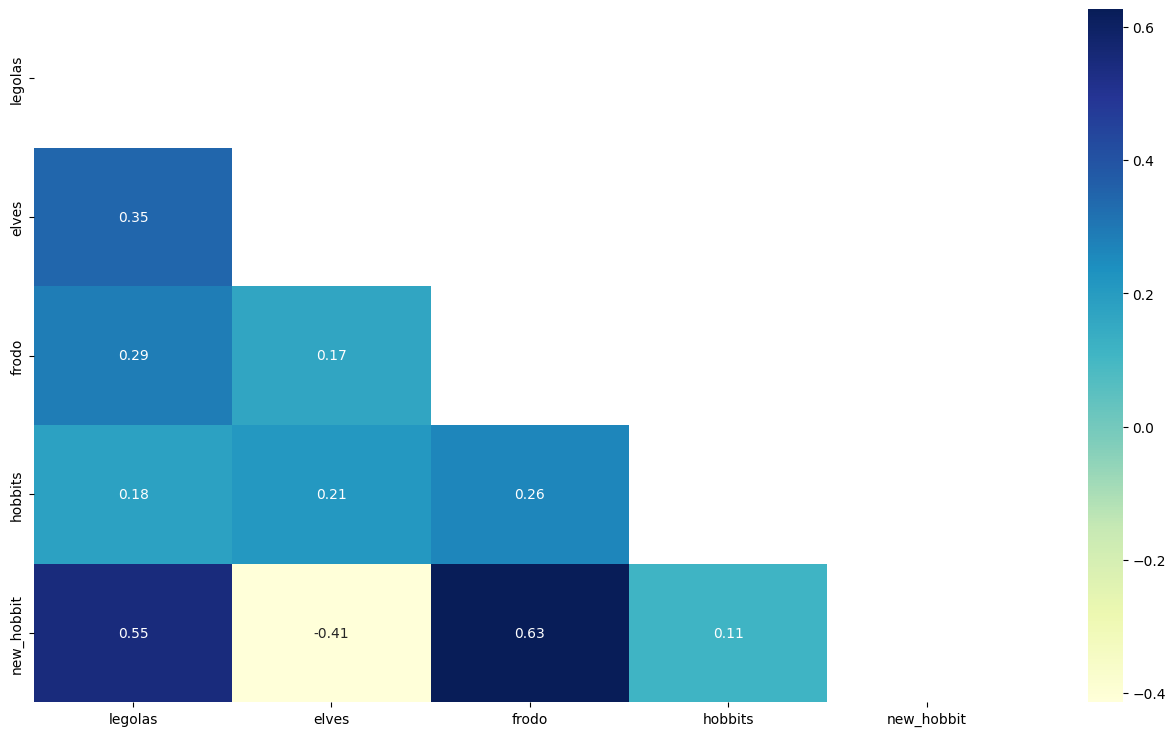

In [160]:
from sklearn.metrics import pairwise
# probamos un test de analogía
test_words = ['legolas', 'elves', 'frodo', 'hobbits']

test_emb = []
for word in test_words:
    test_emb.append(w2v_model.wv.get_vector(word))
    
# legolas - elves + frodo
new_hobbit = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_hobbit']
new_emb = np.append(test_emb, new_hobbit.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

El nuevo vector "new_hobbit" Si bien tiene una similaridad con "hobbits" se ve que tiene mayor similaridad con los nombes de los personajes.

Verifico con que palabras tiene mayor similaridad

In [161]:
# calculamos la similaridad de 'new_hobbit' contra todos los vectores
# puede tardar unos segundos
similarities = np.squeeze(pairwise.cosine_similarity(w2v_model.wv.vectors,np.array([new_hobbit])))

In [162]:
# vemos cuáles son los 10 vectores más similares
args_sorted = np.argsort(similarities)[::-1][:10]
for arg in args_sorted:
  print(f'{labels[arg]}: {similarities[arg]}')

frodo: 0.6265349388122559
legolas: 0.5454933047294617
'look: 0.3614315390586853
he: 0.35905301570892334
'that's: 0.34668493270874023
doubtfully: 0.33701270818710327
picking: 0.3350703716278076
muffled: 0.3334004282951355
smile: 0.3314243257045746
effort: 0.32997754216194153
